In [84]:
%reset -f

In [85]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR

from IPython.display import display, Math, Latex

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [86]:
with open('/Users/cristianosalvagnin/Documents/GitHub/EUA_Volatility_DII_p/Data/quadratic_and_linear_XY_to_Z.p', 'rb') as file:
    traj = pickle.load(file)

In [87]:
scaler = StandardScaler()
scaler.fit(traj)
traj = scaler.transform(traj)

In [88]:
df = pd.DataFrame()
df['Z (Target)'] = traj[:,2]
df['Y'] = traj[:,1]
df['X'] = traj[:,0]
df = df[5000:7902]

In [89]:
df.head()

,Z (Target),Y,X
5000,-1.115592,1.621691,0.325623
5001,0.418250,1.334626,0.674150
5002,1.003085,-0.027051,-0.461683
5003,0.112950,-0.011531,-1.416726
5004,-1.166861,-0.025920,1.345414


In [90]:
model = VAR(df)
var_model = model.fit(maxlags=1, trend='n', verbose=True)  # 1 lag
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 28, Dec, 2024
Time:                     20:25:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  -0.460869
Nobs:                     2901.00    HQIC:                 -0.472722
Log likelihood:          -11644.7    FPE:                   0.619155
AIC:                    -0.479399    Det(Omega_mle):        0.617239
--------------------------------------------------------------------
Results for equation Z (Target)
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
L1.Z (Target)         0.478768         0.014036           34.110           0.000
L1.Y                  0.002084         0.014178            0.147           0.883
L1.X                  0.448049         0.013995        

In [91]:
target_coef = abs(var_model.params['Z (Target)'])

In [92]:
target_coef.index.str.replace('L1.', '')


Index(['Z (Target)', 'Y', 'X'], dtype='object')

In [93]:
target_coef = target_coef.reset_index()
target_coef.columns = ['Variable', 'VAR Coeff.']
print(target_coef)

        Variable  VAR Coeff.
0  L1.Z (Target)    0.478768
1           L1.Y    0.002084
2           L1.X    0.448049


In [94]:
target_coef['Variable'] = target_coef['Variable'].str.replace('L1.', '')
print(target_coef)

     Variable  VAR Coeff.
0  Z (Target)    0.478768
1           Y    0.002084
2           X    0.448049


In [95]:
causality_results = []

for var in df.columns:
    
    causality = var_model.test_causality('Z (Target)', var, kind='f')

    causality_results.append({
        'Excluded Variable': var,
        'F-Statistic': causality.test_statistic,
        'p-value': causality.pvalue
    })

causality_results_df = pd.DataFrame(causality_results)
print(causality_results_df)

  Excluded Variable  F-Statistic        p-value
0        Z (Target)  1163.462970  1.934564e-239
1                 Y     0.021610   8.831338e-01
2                 X  1024.975751  1.051474e-212


In [96]:
with open('/Users/cristianosalvagnin/Documents/GitHub/EUA_Volatility_DII_p/Data/weights_toymodel.p', 'rb') as file:
    DII_toy = pickle.load(file)

In [97]:
df_DII_toy = pd.DataFrame(DII_toy)
df_DII_toy.columns = ['DII Coeff.']
print(df_DII_toy)

   DII Coeff.
0    0.068511
1    0.135314
2    0.083644


In [98]:
df_DII_toy['Variable'] = ['Z (Target)', 'Y', 'X']
df_DII_toy = df_DII_toy[['Variable', 'DII Coeff.']]
print(df_DII_toy)

     Variable  DII Coeff.
0  Z (Target)    0.068511
1           Y    0.135314
2           X    0.083644


In [99]:
merged_df = pd.merge(target_coef, df_DII_toy, on='Variable', how='inner')
print(merged_df)

     Variable  VAR Coeff.  DII Coeff.
0  Z (Target)    0.478768    0.068511
1           Y    0.002084    0.135314
2           X    0.448049    0.083644


In [100]:
causality_results_df = causality_results_df.drop(columns=['p-value'])
causality_results_df.columns = ['Variable', 'F-Statistic']
print(causality_results_df)

     Variable  F-Statistic
0  Z (Target)  1163.462970
1           Y     0.021610
2           X  1024.975751


In [101]:
with open('/Users/cristianosalvagnin/Documents/GitHub/EUA_Volatility_DII_p/Data/IGs_toymodel.p', 'rb') as file:
    IG_toy = pickle.load(file)

print(IG_toy)

[22.49288125 27.72234305 29.15142412]


In [102]:
df_IG_toy = pd.DataFrame(IG_toy)
df_IG_toy.columns = ['IG Coeff.']
print(df_IG_toy)

   IG Coeff.
0  22.492881
1  27.722343
2  29.151424


In [103]:
df_IG_toy['Variable'] = ['Z (Target)', 'Y', 'X']
df_IG_toy = df_IG_toy[['Variable', 'IG Coeff.']]
print(df_IG_toy)

     Variable  IG Coeff.
0  Z (Target)  22.492881
1           Y  27.722343
2           X  29.151424


In [104]:
merged_df_2 = pd.merge(causality_results_df, df_IG_toy, on='Variable', how='inner')
print(merged_df_2)

     Variable  F-Statistic  IG Coeff.
0  Z (Target)  1163.462970  22.492881
1           Y     0.021610  27.722343
2           X  1024.975751  29.151424


In [105]:
variables = target_coef['Variable']
indices = np.arange(len(variables))
bar_width = 0.3

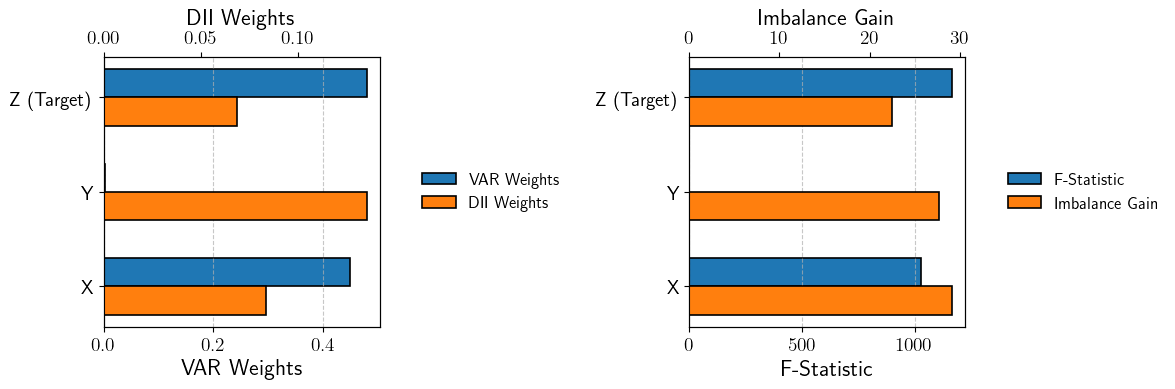

In [106]:


fig, axes = plt.subplots(1, 2, figsize=(12, 10))

bar_kwargs = {"edgecolor": "black", "linewidth": 1.2}

ax1 = axes[0]
ax2 = ax1.twiny()

bar1 = ax1.barh(
    indices - bar_width / 2,
    target_coef["VAR Coeff."], 
    bar_width, 
    color='tab:blue', 
    label="VAR Weights",
    **bar_kwargs
)

bar2 = ax2.barh(
    indices + bar_width / 2,
    df_DII_toy["DII Coeff."], 
    bar_width, 
    color='tab:orange', 
    label="DII Weights",
    **bar_kwargs
)

ax1.set_xlabel("VAR Weights", fontsize=16)
ax2.set_xlabel("DII Weights", fontsize=16)
ax1.set_yticks(indices)
ax1.set_yticklabels(variables, fontsize=14)
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)

ax1.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)

variables = causality_results_df['Variable']
ax3 = axes[1]
ax4 = ax3.twiny()

bar3 = ax3.barh(
    indices - bar_width / 2,
    causality_results_df["F-Statistic"], 
    bar_width, 
    color='tab:blue', 
    label="F-Statistic",
    **bar_kwargs
)

bar4 = ax4.barh(
    indices + bar_width / 2,
    df_IG_toy["IG Coeff."], 
    bar_width, 
    color='tab:orange', 
    label="Imbalance Gain",
    **bar_kwargs
)

ax3.set_xlabel("F-Statistic", fontsize=16)
ax4.set_xlabel("Imbalance Gain", fontsize=16)
ax3.set_yticks(indices)
ax3.set_yticklabels(variables, fontsize=14)
ax3.invert_yaxis()
ax3.grid(axis='x', linestyle='--', alpha=0.7)

ax3.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='x', labelsize=14)

handles_left = [bar1, bar2]
labels_left = ["VAR Weights", "DII Weights"]
handles_right = [bar3, bar4]
labels_right = ["F-Statistic", "Imbalance Gain"]

axes[0].legend(
    handles_left, labels_left, loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12, frameon=False
)
axes[1].legend(
    handles_right, labels_right, loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12, frameon=False
)

plt.tight_layout(rect=[0, 0.1, 1, 0.5])
plt.show()


<>:56: SyntaxWarning: invalid escape sequence '\%'
<>:61: SyntaxWarning: invalid escape sequence '\%'
<>:74: SyntaxWarning: invalid escape sequence '\%'
<>:56: SyntaxWarning: invalid escape sequence '\%'
<>:61: SyntaxWarning: invalid escape sequence '\%'
<>:74: SyntaxWarning: invalid escape sequence '\%'
/var/folders/n3/rjkcm_2n3lj8mx3d7mkrnpb40000gn/T/ipykernel_4571/4196845417.py:56: SyntaxWarning: invalid escape sequence '\%'
  label="Imbalance Gain (\%)",
/var/folders/n3/rjkcm_2n3lj8mx3d7mkrnpb40000gn/T/ipykernel_4571/4196845417.py:61: SyntaxWarning: invalid escape sequence '\%'
  ax4.set_xlabel("Imbalance Gain (\%)", fontsize=16)
/var/folders/n3/rjkcm_2n3lj8mx3d7mkrnpb40000gn/T/ipykernel_4571/4196845417.py:74: SyntaxWarning: invalid escape sequence '\%'
  labels_right = ["F-Statistic", "Imbalance Gain (\%)"]


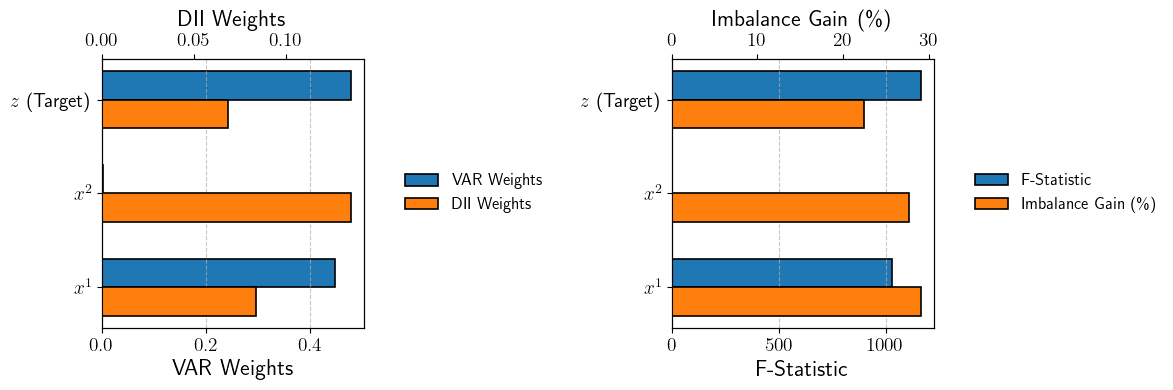

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10))

bar_kwargs = {"edgecolor": "black", "linewidth": 1.2}

ax1 = axes[0]
ax2 = ax1.twiny()

bar1 = ax1.barh(
    indices - bar_width / 2,
    target_coef["VAR Coeff."], 
    bar_width, 
    color='tab:blue', 
    label="VAR Weights",
    **bar_kwargs
)

bar2 = ax2.barh(
    indices + bar_width / 2,
    df_DII_toy["DII Coeff."], 
    bar_width, 
    color='tab:orange', 
    label="DII Weights",
    **bar_kwargs
)

ax1.set_xlabel("VAR Weights", fontsize=16)
ax2.set_xlabel("DII Weights", fontsize=16)

y_labels = [r"$z$ (Target)", r"$x^{2}$", r"$x^{1}$"]
ax1.set_yticks(indices)
ax1.set_yticklabels(y_labels, fontsize=14)
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)

ax1.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)

variables = causality_results_df['Variable']
ax3 = axes[1]
ax4 = ax3.twiny()

bar3 = ax3.barh(
    indices - bar_width / 2,
    causality_results_df["F-Statistic"], 
    bar_width, 
    color='tab:blue', 
    label="F-Statistic",
    **bar_kwargs
)

bar4 = ax4.barh(
    indices + bar_width / 2,
    df_IG_toy["IG Coeff."], 
    bar_width, 
    color='tab:orange', 
    label="Imbalance Gain (\%)",
    **bar_kwargs
)

ax3.set_xlabel("F-Statistic", fontsize=16)
ax4.set_xlabel("Imbalance Gain (\%)", fontsize=16)

ax3.set_yticks(indices)
ax3.set_yticklabels(y_labels, fontsize=14)
ax3.invert_yaxis()
ax3.grid(axis='x', linestyle='--', alpha=0.7)

ax3.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='x', labelsize=14)

handles_left = [bar1, bar2]
labels_left = ["VAR Weights", "DII Weights"]
handles_right = [bar3, bar4]
labels_right = ["F-Statistic", "Imbalance Gain (\%)"]

axes[0].legend(
    handles_left, labels_left, loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12, frameon=False
)
axes[1].legend(
    handles_right, labels_right, loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12, frameon=False
)

plt.tight_layout(rect=[0, 0.1, 1, 0.5])
plt.show()

***

In [108]:
%reset -f

In [109]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR

from IPython.display import display, Math, Latex

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [110]:
with open('/Users/cristianosalvagnin/Documents/GitHub/EUA_Volatility_DII_p/Data/confounder_quadratic_Y_to_XZ_v3.p', 'rb') as file:
    traj = pickle.load(file)

In [111]:
scaler = StandardScaler()
scaler.fit(traj)
traj = scaler.transform(traj)

In [112]:
df = pd.DataFrame()
df['Z (Target)'] = traj[:,2]
df['Y'] = traj[:,1]
df['X'] = traj[:,0]
df = df[5000:7902]

In [113]:
df.head()

,Z (Target),Y,X
5000,-0.806489,1.376605,-0.520916
5001,0.083899,1.913730,0.647094
5002,1.111190,1.320204,1.575082
5003,1.118611,0.915787,0.208570
5004,0.222619,0.622449,0.238512


In [114]:
model = VAR(df)
var_model = model.fit(maxlags=1, trend='n', verbose=True)  # 1 lag
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 28, Dec, 2024
Time:                     20:25:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.72881
Nobs:                     2901.00    HQIC:                  -1.74066
Log likelihood:          -9805.51    FPE:                   0.174237
AIC:                     -1.74734    Det(Omega_mle):        0.173698
--------------------------------------------------------------------
Results for equation Z (Target)
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
L1.Z (Target)         0.498362         0.017566           28.370           0.000
L1.Y                  0.014695         0.014274            1.029           0.303
L1.X                  0.215879         0.017282        

In [115]:
target_coef = abs(var_model.params['Z (Target)'])

In [116]:
target_coef.index.str.replace('L1.', '')


Index(['Z (Target)', 'Y', 'X'], dtype='object')

In [117]:
target_coef = target_coef.reset_index()
target_coef.columns = ['Variable', 'VAR Coeff.']
print(target_coef)

        Variable  VAR Coeff.
0  L1.Z (Target)    0.498362
1           L1.Y    0.014695
2           L1.X    0.215879


In [118]:
target_coef['Variable'] = target_coef['Variable'].str.replace('L1.', '')
print(target_coef)

     Variable  VAR Coeff.
0  Z (Target)    0.498362
1           Y    0.014695
2           X    0.215879


In [119]:
causality_results = []

for var in df.columns:
    
    causality = var_model.test_causality('Z (Target)', var, kind='f')

    causality_results.append({
        'Excluded Variable': var,
        'F-Statistic': causality.test_statistic,
        'p-value': causality.pvalue
    })

causality_results_df = pd.DataFrame(causality_results)
print(causality_results_df)

  Excluded Variable  F-Statistic        p-value
0        Z (Target)   804.877187  2.061291e-169
1                 Y     1.059823   3.032841e-01
2                 X   156.042587   1.669953e-35


In [120]:
with open('/Users/cristianosalvagnin/Documents/GitHub/EUA_Volatility_DII_p/Data/weights_toymodel2.p', 'rb') as file:
    DII_toy = pickle.load(file)

In [121]:
df_DII_toy = pd.DataFrame(DII_toy)
df_DII_toy.columns = ['DII Coeff.']
print(df_DII_toy)

   DII Coeff.
0    0.026060
1    0.140028
2    0.098555


In [122]:
df_DII_toy['Variable'] = ['Z (Target)', 'Y', 'X']
df_DII_toy = df_DII_toy[['Variable', 'DII Coeff.']]
print(df_DII_toy)

     Variable  DII Coeff.
0  Z (Target)    0.026060
1           Y    0.140028
2           X    0.098555


In [123]:
merged_df = pd.merge(target_coef, df_DII_toy, on='Variable', how='inner')
print(merged_df)

     Variable  VAR Coeff.  DII Coeff.
0  Z (Target)    0.498362    0.026060
1           Y    0.014695    0.140028
2           X    0.215879    0.098555


In [124]:
causality_results_df = causality_results_df.drop(columns=['p-value'])
causality_results_df.columns = ['Variable', 'F-Statistic']
print(causality_results_df)

     Variable  F-Statistic
0  Z (Target)   804.877187
1           Y     1.059823
2           X   156.042587


In [125]:
with open('/Users/cristianosalvagnin/Documents/GitHub/EUA_Volatility_DII_p/Data/IGs_toymodel2.p', 'rb') as file:
    IG_toy = pickle.load(file)

print(IG_toy)

[ 0.2062762   7.19913119 10.31711232]


In [126]:
df_IG_toy = pd.DataFrame(IG_toy)
df_IG_toy.columns = ['IG Coeff.']
print(df_IG_toy)

   IG Coeff.
0   0.206276
1   7.199131
2  10.317112


In [127]:
df_IG_toy['Variable'] = ['Z (Target)', 'Y', 'X']
df_IG_toy = df_IG_toy[['Variable', 'IG Coeff.']]
print(df_IG_toy)

     Variable  IG Coeff.
0  Z (Target)   0.206276
1           Y   7.199131
2           X  10.317112


In [128]:
merged_df_2 = pd.merge(causality_results_df, df_IG_toy, on='Variable', how='inner')
print(merged_df_2)

     Variable  F-Statistic  IG Coeff.
0  Z (Target)   804.877187   0.206276
1           Y     1.059823   7.199131
2           X   156.042587  10.317112


In [129]:
variables = target_coef['Variable']
indices = np.arange(len(variables))
bar_width = 0.3

<>:56: SyntaxWarning: invalid escape sequence '\%'
<>:61: SyntaxWarning: invalid escape sequence '\%'
<>:74: SyntaxWarning: invalid escape sequence '\%'
<>:56: SyntaxWarning: invalid escape sequence '\%'
<>:61: SyntaxWarning: invalid escape sequence '\%'
<>:74: SyntaxWarning: invalid escape sequence '\%'
/var/folders/n3/rjkcm_2n3lj8mx3d7mkrnpb40000gn/T/ipykernel_4571/4196845417.py:56: SyntaxWarning: invalid escape sequence '\%'
  label="Imbalance Gain (\%)",
/var/folders/n3/rjkcm_2n3lj8mx3d7mkrnpb40000gn/T/ipykernel_4571/4196845417.py:61: SyntaxWarning: invalid escape sequence '\%'
  ax4.set_xlabel("Imbalance Gain (\%)", fontsize=16)
/var/folders/n3/rjkcm_2n3lj8mx3d7mkrnpb40000gn/T/ipykernel_4571/4196845417.py:74: SyntaxWarning: invalid escape sequence '\%'
  labels_right = ["F-Statistic", "Imbalance Gain (\%)"]


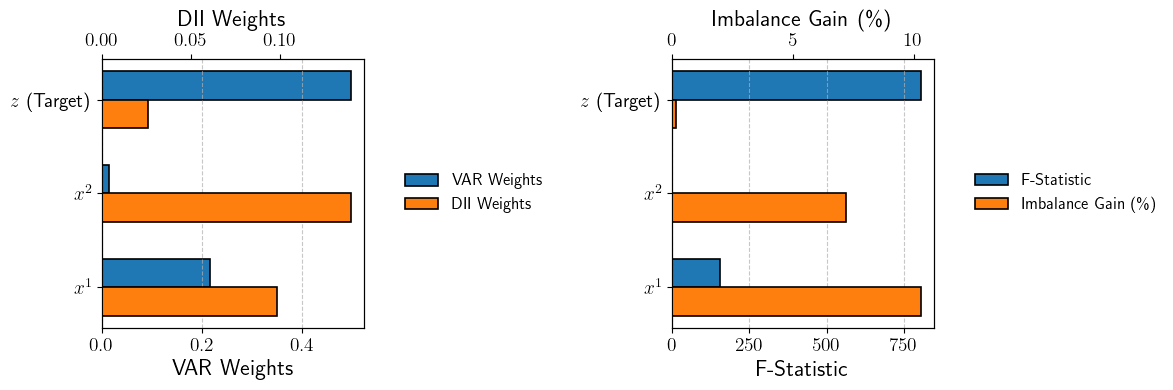

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10))

bar_kwargs = {"edgecolor": "black", "linewidth": 1.2}

ax1 = axes[0]
ax2 = ax1.twiny()

bar1 = ax1.barh(
    indices - bar_width / 2,
    target_coef["VAR Coeff."], 
    bar_width, 
    color='tab:blue', 
    label="VAR Weights",
    **bar_kwargs
)

bar2 = ax2.barh(
    indices + bar_width / 2,
    df_DII_toy["DII Coeff."], 
    bar_width, 
    color='tab:orange', 
    label="DII Weights",
    **bar_kwargs
)

ax1.set_xlabel("VAR Weights", fontsize=16)
ax2.set_xlabel("DII Weights", fontsize=16)

y_labels = [r"$z$ (Target)", r"$x^{2}$", r"$x^{1}$"]
ax1.set_yticks(indices)
ax1.set_yticklabels(y_labels, fontsize=14)
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)

ax1.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)

variables = causality_results_df['Variable']
ax3 = axes[1]
ax4 = ax3.twiny()

bar3 = ax3.barh(
    indices - bar_width / 2,
    causality_results_df["F-Statistic"], 
    bar_width, 
    color='tab:blue', 
    label="F-Statistic",
    **bar_kwargs
)

bar4 = ax4.barh(
    indices + bar_width / 2,
    df_IG_toy["IG Coeff."], 
    bar_width, 
    color='tab:orange', 
    label="Imbalance Gain (\%)",
    **bar_kwargs
)

ax3.set_xlabel("F-Statistic", fontsize=16)
ax4.set_xlabel("Imbalance Gain (\%)", fontsize=16)

ax3.set_yticks(indices)
ax3.set_yticklabels(y_labels, fontsize=14)
ax3.invert_yaxis()
ax3.grid(axis='x', linestyle='--', alpha=0.7)

ax3.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='x', labelsize=14)

handles_left = [bar1, bar2]
labels_left = ["VAR Weights", "DII Weights"]
handles_right = [bar3, bar4]
labels_right = ["F-Statistic", "Imbalance Gain (\%)"]

axes[0].legend(
    handles_left, labels_left, loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12, frameon=False
)
axes[1].legend(
    handles_right, labels_right, loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12, frameon=False
)

plt.tight_layout(rect=[0, 0.1, 1, 0.5])
plt.show()